# Ejercicios de Práctica # 5

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import descartes 
import geopandas as gpd
import numpy as np 
from scipy.stats import wilcoxon
from scipy.stats import iqr
from datetime import datetime
import folium
from folium.plugins import HeatMap
from shapely.geometry import shape
from shapely.validation import make_valid
import warnings        
warnings.filterwarnings("ignore") 

# Parte 1

En esta actividad, se trabajará con una base de datos titulada Accidentalidad en Barranquilla, proporcionada por la Alcaldía Distrital de Barranquilla. Esta base contiene información sobre accidentes de tránsito ocurridos en el distrito de Barranquilla, obtenida de los informes policiales de accidentes de tránsito (IPAT). La base proporciona un registro detallado de cada accidente, permitiendo análisis sobre la frecuencia, severidad y ubicación de los accidentes en la ciudad.

In [137]:
df = pd.read_csv("C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/Accidentalidad_en_Barranquilla_20240826.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_') # Limpiar nombres de columnas

El análisis preliminar de la base de datos muestra que contiene 11 variables y 25,610 observaciones.

In [138]:
df.shape

(25610, 11)

Un examen superficial de las variables indica que algunas necesitarán ser normalizadas, renombradas o reformateadas para facilitar los análisis posteriores.

In [139]:
descripcion_df = pd.DataFrame({
    'Nombre_original': ["fecha_accidente", "hora_accidente", "gravedad_accidente", "clase_accidente", "sitio_exacto_accidente",
                        "cant_heridos_en_sitio_accidente", "cant_muertos_en_sitio_accidente", "cantidad_accidentes", "ano_accidente",
                        "mes_accidente", "dia_accidente"],
    'Nombre_recodificado': ["Fecha", "Hora", "Gravedad", "Clase", "Sitio", "Heridos", "Muertos", "Cantidad", "Año", "Mes", "Día"],
    'Tipo_original': ["Fecha", "Cadena", "Cadena", "Cadena", "Cadena", "Numérico", "Numérico", "Numérico", "Numérico", "Cadena", "Cadena"],
    'Tipo_modificado': ["Fecha", "Hora", "Categoría", "Categoría", "Cadena", "Numérico", "Numérico", "Numérico", "Numérico", "Categoría", "Categoría"]
})
descripcion_df

,Nombre_original,Nombre_recodificado,Tipo_original,Tipo_modificado
0,fecha_accidente,Fecha,Fecha,Fecha
1,hora_accidente,Hora,Cadena,Hora
2,gravedad_accidente,Gravedad,Cadena,Categoría
3,clase_accidente,Clase,Cadena,Categoría
4,sitio_exacto_accidente,Sitio,Cadena,Cadena
5,cant_heridos_en_sitio_accidente,Heridos,Numérico,Numérico
6,cant_muertos_en_sitio_accidente,Muertos,Numérico,Numérico
7,cantidad_accidentes,Cantidad,Numérico,Numérico
8,ano_accidente,Año,Numérico,Numérico
9,mes_accidente,Mes,Cadena,Categoría


Para examinar los datos almacenados en cada variable y determinar la presencia de datos faltantes, se utiliza la función `describe()` en pandas:

In [140]:
df.describe(include='all')

,fecha_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en__sitio_accidente,cant_muertos_en__sitio_accidente,cantidad_accidentes,año_accidente,mes_accidente,dia_accidente
count,25610,25610,25610,25610,25610,9984.000000,252.000000,25610.000000,25610.000000,25610,25610
unique,2357,871,3,6,15365,NaN,NaN,NaN,NaN,12,7
top,2018-06-08T00:00:00.000,04:00:00:pm,Solo daños,Choque,CL 110 CR 9G,NaN,NaN,NaN,NaN,February,Tue
freq,34,408,15457,23819,77,NaN,NaN,NaN,NaN,2477,4009
mean,NaN,NaN,NaN,NaN,NaN,1.471655,1.035714,1.000195,2020.100547,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.156751,0.185946,0.013972,1.713887,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2018.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2019.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2020.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,2021.000000,NaN,NaN


Tras el análisis preliminar de la base, se estudiarán las variables individualmente. Primero, se modificarán los nombres de las columnas y se cambiará el tipo de datos de algunas variables:

In [141]:
# Renombrar columnas
df.columns = ["Fecha", "Hora", "Gravedad", "Clase", "Sitio", "Heridos", "Muertos", "Cantidad", "Año", "Mes", "Día"]

# Convertir tipos de datos
df["Gravedad"] = df["Gravedad"].astype('category')
df["Clase"] = df["Clase"].astype('category')
df["Mes"] = df["Mes"].astype('category')
df["Día"] = df["Día"].astype('category')
df["Fecha"] = pd.to_datetime(df["Fecha"], errors='coerce')

## Estudio de las Variables

### Fecha

En primera instancia, la variable `Fecha` no presenta problemas relacionados con la digitación o los datos faltantes:

In [142]:
df['Fecha'].isna().sum()

np.int64(0)

Se visualizará la variable mediante un histograma:

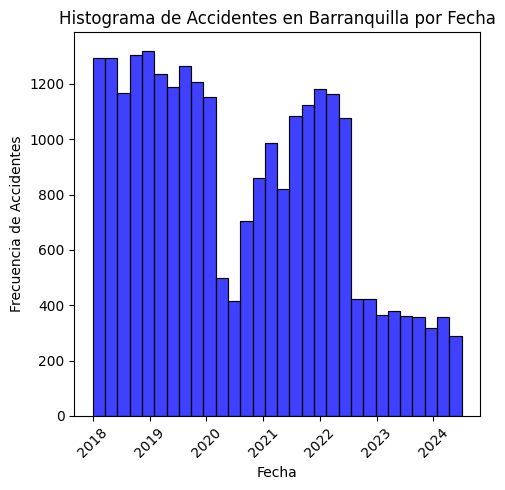

In [143]:
plt.figure(figsize=(5, 5))
sns.histplot(df['Fecha'], bins=30, color='blue', edgecolor='black')
plt.title('Histograma de Accidentes en Barranquilla por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de Accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Hora

La variable `Hora` almacena las horas en que ocurrieron los accidentes. Cambiaremos el tipo de la variable a hora utilizando `pd.to_datetime`. Primero, normalizamos el contenido y eliminamos caracteres que pueden dificultar la conversión:

In [144]:
df['Hora'] = df['Hora'].str.replace(r'(:\w{2})$', '', regex=True)
df['Hora'] = df['Hora'].str.strip()
df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S', errors='coerce').dt.time

Luego, aseguramos que no haya datos faltantes y calculamos estadísticas descriptivas:

In [148]:
# Contar los valores faltantes después de la conversión
df['Hora'].isna().sum()

np.int64(0)

In [146]:
# Convertir 'Hora' a una cadena para aplicar pd.to_timedelta
df['Hora'] = pd.to_timedelta(df['Hora'].astype(str))
# Extraer las horas totales en formato de segundos y luego dividir para obtener solo las horas
df['Hora_hora'] = df['Hora'].dt.total_seconds() // 3600

In [149]:
df['Hora'].describe()

count                        25610
mean     0 days 07:03:52.608356110
std      0 days 03:18:01.911900763
min                0 days 01:00:00
25%                0 days 04:25:00
50%                0 days 07:15:00
75%                0 days 09:40:00
max                0 days 12:58:00
Name: Hora, dtype: object

### Gravedad

La variable `Gravedad` indica la gravedad del accidente. Comenzamos construyendo una tabla de frecuencia para determinar el número de observaciones en cada condición y la posible existencia de datos faltantes:

In [150]:
df['Gravedad'].value_counts()

Gravedad
Solo daños     15457
Con heridos     9901
Con muertos      252
Name: count, dtype: int64

In [151]:
df['Gravedad'].isna().sum()

np.int64(0)

Como la tabla muestra que no hay datos faltantes, procedemos a crear una tabla con el conteo y el porcentaje de accidentes según su gravedad:

In [152]:
tabla_gravedad = df.groupby('Gravedad').size().reset_index(name='Conteo')
tabla_gravedad['Proporción'] = tabla_gravedad['Conteo'] / tabla_gravedad['Conteo'].sum()
tabla_gravedad['Porcentaje'] = (tabla_gravedad['Proporción'] * 100).round(2).astype(str) + '%'

tabla_gravedad

,Gravedad,Conteo,Proporción,Porcentaje
0,Con heridos,9901,0.386607,38.66%
1,Con muertos,252,0.009840,0.98%
2,Solo daños,15457,0.603553,60.36%


Utilizamos esta tabla para crear un diagrama de barras que muestra la cantidad de accidentes según su gravedad:

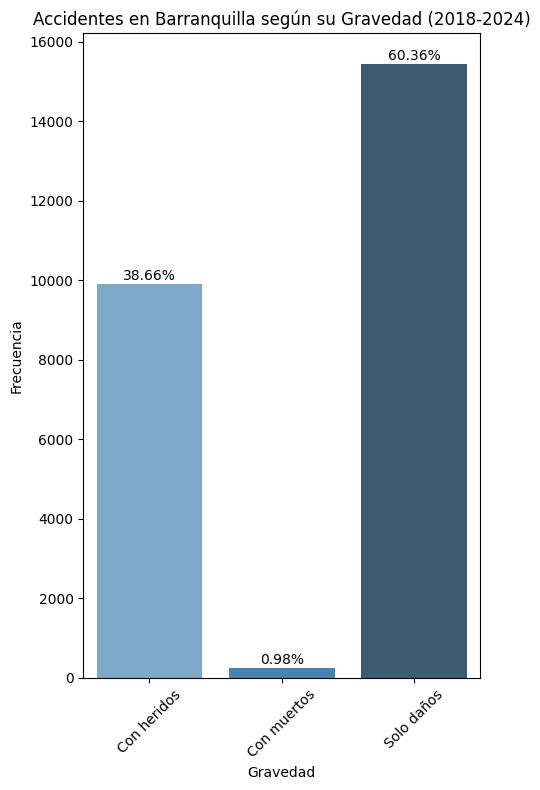

In [30]:
plt.figure(figsize=(5, 8))
sns.barplot(data=tabla_gravedad, x='Gravedad', y='Conteo', palette='Blues_d')
for index, row in tabla_gravedad.iterrows():
    plt.text(row.name, row['Conteo'] + 100, row['Porcentaje'], ha='center')
plt.title('Accidentes en Barranquilla según su Gravedad (2018-2024)')
plt.xlabel('Gravedad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Clase de Accidente

La variable `Clase` indica la clase de accidente. Construimos una tabla de frecuencias para verificar el número de observaciones por condición y comprobar datos faltantes:

In [153]:
df['Clase'].value_counts()

Clase
Choque            23819
Atropello          1344
Caida Ocupante      194
Otro                123
Volcamiento         117
Incendio             13
Name: count, dtype: int64

In [32]:
df['Clase'].isna().sum()

np.int64(0)

Como la tabla muestra que no hay datos faltantes, creamos una tabla con el conteo y el porcentaje de accidentes según su tipo:

In [33]:
df['Clase'] = df['Clase'].replace('Caida Ocupante', 'Caída')

tabla_clase = df.groupby('Clase').size().reset_index(name='Conteo')
tabla_clase['Proporción'] = tabla_clase['Conteo'] / tabla_clase['Conteo'].sum()
tabla_clase['Porcentaje'] = (tabla_clase['Proporción'] * 100).round(2).astype(str) + '%'

tabla_clase

,Clase,Conteo,Proporción,Porcentaje
0,Atropello,1344,0.052480,5.25%
1,Caída,194,0.007575,0.76%
2,Choque,23819,0.930066,93.01%
3,Incendio,13,0.000508,0.05%
4,Otro,123,0.004803,0.48%
5,Volcamiento,117,0.004569,0.46%


Creamos un diagrama de barras para visualizar la cantidad de accidentes según su clase:

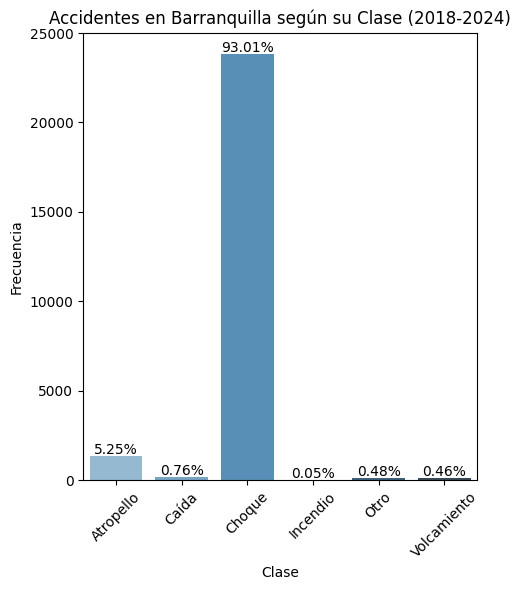

In [41]:
plt.figure(figsize=(5, 6))
sns.barplot(data=tabla_clase, x='Clase', y='Conteo', palette='Blues_d')
for index, row in tabla_clase.iterrows():
    plt.text(row.name, row['Conteo'] + 100, row['Porcentaje'], ha='center')
plt.title('Accidentes en Barranquilla según su Clase (2018-2024)')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Año

Para la variable `Año`, comenzamos construyendo una tabla de frecuencia para comprobar datos faltantes y calculando estadísticas descriptivas. Luego, visualizamos el número de accidentes a lo largo de los años:

In [35]:
df['Año'].value_counts()

Año
2018    5898
2019    5645
2021    4700
2022    3683
2020    3281
2023    1662
2024     741
Name: count, dtype: int64

In [36]:
tabla_año = df.groupby('Año').size().reset_index(name='Conteo')
tabla_año['Proporción'] = tabla_año['Conteo'] / tabla_año['Conteo'].sum()
tabla_año['Porcentaje'] = (tabla_año['Proporción'] * 100).round(2).astype(str) + '%'

tabla_año

,Año,Conteo,Proporción,Porcentaje
0,2018,5898,0.230301,23.03%
1,2019,5645,0.220422,22.04%
2,2020,3281,0.128114,12.81%
3,2021,4700,0.183522,18.35%
4,2022,3683,0.143811,14.38%
5,2023,1662,0.064897,6.49%
6,2024,741,0.028934,2.89%


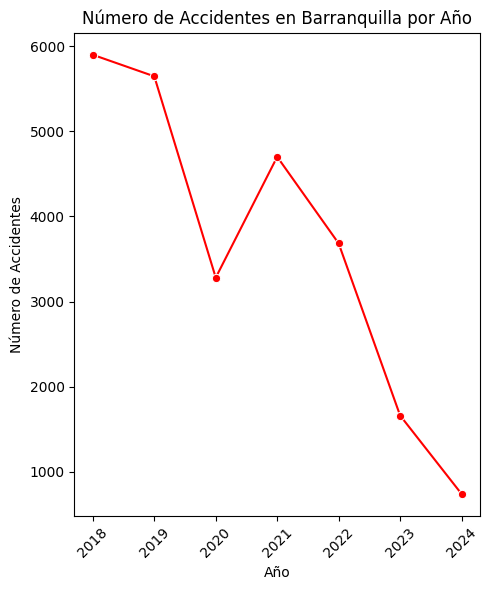

In [40]:
plt.figure(figsize=(5, 6))
sns.lineplot(data=tabla_año, x='Año', y='Conteo', marker='o', color='red')
plt.title('Número de Accidentes en Barranquilla por Año')
plt.xlabel('Año')
plt.ylabel('Número de Accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mes y Día

Para las variables `Mes` y `Día`, creamos tablas de frecuencia para cada una y generamos gráficos de barras para visualizar la distribución de los accidentes a lo largo del año y de la semana:

In [154]:
df['Mes'].value_counts()

Mes
February     2477
March        2446
January      2349
December     2189
May          2121
June         2103
October      2090
April        2010
November     1995
September    1980
July         1932
August       1918
Name: count, dtype: int64

In [44]:
df['Día'].value_counts()

Día
Tue    4009
Fri    3920
Wed    3839
Mon    3774
Thu    3756
Sat    3735
Sun    2577
Name: count, dtype: int64

In [48]:
tabla_mes = df.groupby('Mes').size().reset_index(name='Conteo')
tabla_mes['Proporción'] = tabla_mes['Conteo'] / tabla_mes['Conteo'].sum()
tabla_mes['Porcentaje'] = (tabla_mes['Proporción'] * 100).round(2).astype(str) + '%'
tabla_mes

,Mes,Conteo,Proporción,Porcentaje
0,April,2010,0.078485,7.85%
1,August,1918,0.074893,7.49%
2,December,2189,0.085474,8.55%
3,February,2477,0.096720,9.67%
4,January,2349,0.091722,9.17%
5,July,1932,0.075439,7.54%
6,June,2103,0.082116,8.21%
7,March,2446,0.095510,9.55%
8,May,2121,0.082819,8.28%
9,November,1995,0.077899,7.79%


In [156]:
tabla_dia = df.groupby('Día').size().reset_index(name='Conteo')
tabla_dia['Proporción'] = tabla_dia['Conteo'] / tabla_dia['Conteo'].sum()
tabla_dia['Porcentaje'] = (tabla_dia['Proporción'] * 100).round(2).astype(str) + '%'
tabla_dia 

,Día,Conteo,Proporción,Porcentaje
0,Fri,3920,0.153065,15.31%
1,Mon,3774,0.147364,14.74%
2,Sat,3735,0.145841,14.58%
3,Sun,2577,0.100625,10.06%
4,Thu,3756,0.146661,14.67%
5,Tue,4009,0.156540,15.65%
6,Wed,3839,0.149902,14.99%


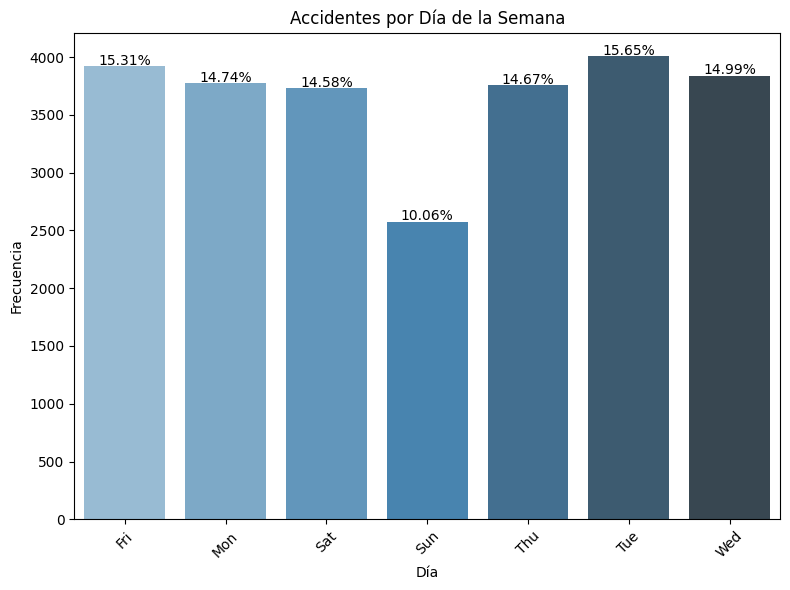

In [157]:
plt.figure(figsize=(8, 6))
sns.barplot(data=tabla_dia, x='Día', y='Conteo', palette='Blues_d')
for index, row in tabla_dia.iterrows():
    plt.text(row.name, row['Conteo'] + 10, row['Porcentaje'], ha='center')
plt.title('Accidentes por Día de la Semana')
plt.xlabel('Día')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

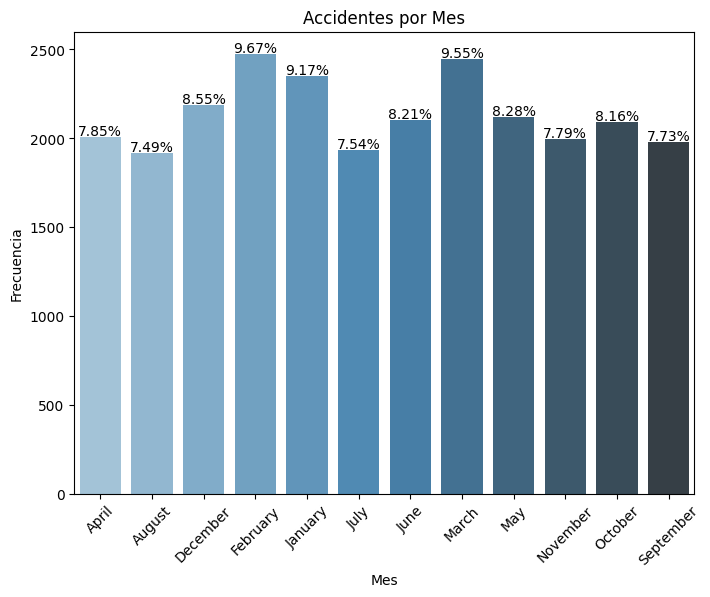

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(data=tabla_mes, x='Mes', y='Conteo', palette='Blues_d')
for index, row in tabla_mes.iterrows():
    plt.text(row.name, row['Conteo'] + 10, row['Porcentaje'], ha='center')
plt.title('Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

### Sitio

In [8]:
file_path = "C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/accidentes_lon_lat.xlsx"
resultados = pd.read_excel(file_path)
resultados_clean = resultados.dropna(subset=['lat', 'lon'])

In [32]:
mapa = folium.Map(location=[10.9639, -74.7967], zoom_start=12)
heat_data = [[row['lat'], row['lon']] for index, row in resultados_clean.iterrows()]
HeatMap(
    heat_data,
    radius=4,       # Ajusta el radio de los puntos en el mapa
    blur=5,         # Ajusta el desenfoque de los puntos
    max_zoom=10     # Ajusta el nivel máximo de zoom para el mapa de calor
).add_to(mapa)

In [33]:
mapa.save("mapa_accidentes_barranquilla.html")
mapa

### Heridos

Para las variables `Heridos` y `Muertos`, se verifica la cantidad de datos faltantes y se calcula la estadística descriptiva para cada variable. Luego se crea un gráfico para visualizar la cantidad total de heridos y muertos en los accidentes:

Ahora procedemos a examinar por posible datos faltantes:

In [159]:
df['Heridos'].isna().sum()

np.int64(15626)

Los resultados nos muestran que hacen faltan 15626 observaciones en la variable `Heridos`, alrededor de un 61% del número total del observaciones. Procedemos a examinar cinco de ellas:

In [160]:
df.groupby('Gravedad').agg(
    total=('Heridos', 'size'),
    Casos=('Heridos', lambda x: x.isna().sum()),
    Proporcion=('Heridos', lambda x: round(x.isna().mean(), 2)),
    Procentaje=('Heridos', lambda x: round(x.isna().mean() * 100, 3))
).reset_index()

,Gravedad,total,Casos,Proporcion,Procentaje
0,Con heridos,9901,0,0.00,0.000
1,Con muertos,252,169,0.67,67.063
2,Solo daños,15457,15457,1.00,100.000


Resulta evidente que el número de datos faltantes esta relacionado con la gravedad del accidente. Vemos por ejemplo que no hay datos faltantes en la categoria de "con heridos", mientras que no datos sobre el número de heridos en la categoria de "solo dyears". Este tipo de datos faltantes se podría considerar como datos "no al azar" (`MANAR` - Missing Not at Random), ya que la ausencia de datos parece depender directamente de la gravedad del accidente. Esto implica que el tratamiento de estos datos faltantes debe hacerse con cuidado, y probablemente no se deba imputar o ignorar sin una estrategia que considere la estructura de los datos y su relación con la variable `Gravedad`.

En este caso comenzaremos por reemplazar los NA con ceros en la categoría de "Solo dyears". Esto se debe a que la ausencia de datos en la variable  `Heridos` podría interpretarse como que no hubo heridos, lo cual es coherente con la categoría "Solo daños".

In [162]:
df['Heridos'] = df.apply(lambda x: 0 if pd.isna(x['Heridos']) and x['Gravedad'] not in ["Con heridos", "Con muertos"] else x['Heridos'], axis=1)

df.groupby('Gravedad').agg(
    total=('Heridos', 'size'),
    Casos=('Heridos', lambda x: x.isna().sum()),
    Proporcion=('Heridos', lambda x: round(x.isna().mean(), 2)),
    Procentaje=('Heridos', lambda x: round(x.isna().mean() * 100, 3))
).reset_index()

,Gravedad,total,Casos,Proporcion,Procentaje
0,Con heridos,9901,0,0.00,0.000
1,Con muertos,252,169,0.67,67.063
2,Solo daños,15457,0,0.00,0.000


Dado que, por el momento, no contamos con suficiente información para tratar con los faltantes en la categoria de "Con muestros" el analisis de la varibale `Heridos` se suspendera para analizar el comportamiento de los datos faltantes en al varibale `Muertos`.

### Muertos

En la base de datos en cuestión, la varibale `Muertos` indica el número de fallecimiento en un determinado accidente. Procedemos de manera parecida a la variable anterior.

In [164]:
df['Muertos'].value_counts()

Muertos
1.0    243
2.0      9
Name: count, dtype: int64

En un primer momento, observamos que solo en dos casos la cantidad de fallecidos fue de nuevo, mientras que los accidentes restantes (de los cuales se tienen datos) solo resultaron en un fallecimiento. Ahora procedemos a revisar el número de datos faltantes:

In [165]:
df['Muertos'].isna().sum()

np.int64(25358)

Tal como en la varibale anterior, los resultados nos muestran que hacen faltan 25358 observaciones en la variable `Muertos`, alrededor de un 99% del número total de observaciones:

In [166]:
df.groupby('Gravedad').agg(
    total=('Muertos', 'size'),
    Casos=('Muertos', lambda x: x.isna().sum()),
    Proporcion=('Muertos', lambda x: round(x.isna().mean(), 2)),
    Procentaje=('Muertos', lambda x: round(x.isna().mean() * 100, 3))
).reset_index()

,Gravedad,total,Casos,Proporcion,Procentaje
0,Con heridos,9901,9901,1.0,100.0
1,Con muertos,252,0,0.0,0.0
2,Solo daños,15457,15457,1.0,100.0


Una vez más, los datos faltantes parecen estar fuertemente relacionados con la gravedad del accidente. En este caso, las categorías "Solo dyears" y "Con heridos" no tienen datos para la variable Muertos. Naturalmente, esto indica que los datos faltantes no son `MAR` (Missing At Random) y la imputación no es una estrategia adecuada en este contexto. Además, la estructura de los datos faltantes sugiere que el registro de heridos y muertos está determinado por la gravedad del accidente.

Como hipótesis, es posible que en los casos en que la gravedad del accidente fue "Con muertos", se hayan involucrado personas que, aunque no fallecieron, resultaron heridas, por lo que se registran valores en ambas variables. Sin embargo, si el accidente solo resultó en personas heridas, tiene sentido que solo se reporte este número, y los datos sobre muertos sean faltantes. Asimismo, si el accidente solo involucró dyears materiales, ambas variables Heridos y Muertos deberían estar faltantes. Esto explicaría la estructura encontrada.

In [167]:
df['Muertos'] = df.apply(lambda x: 0 if pd.isna(x['Muertos']) and x['Gravedad'] != "Con muertos" else x['Muertos'], axis=1)

In [168]:
df.groupby('Gravedad').agg(
    total=('Muertos', 'size'),
    Casos=('Muertos', lambda x: x.isna().sum()),
    Proporcion=('Muertos', lambda x: round(x.isna().mean(), 2)),
    Procentaje=('Muertos', lambda x: round(x.isna().mean() * 100, 3))
).reset_index()

,Gravedad,total,Casos,Proporcion,Procentaje
0,Con heridos,9901,0,0.0,0.0
1,Con muertos,252,0,0.0,0.0
2,Solo daños,15457,0,0.0,0.0


In [169]:
df.describe()

,Fecha,Hora,Heridos,Muertos,Cantidad,Año,Hora_hora
count,25610,25610,25441.000000,25610.000000,25610.000000,25610.000000,25610.000000
mean,2020-07-31 19:57:36.056228096,0 days 07:03:52.608356110,0.577532,0.010191,1.000195,2020.100547,6.680086
min,2018-01-01 00:00:00,0 days 01:00:00,0.000000,0.000000,1.000000,2018.000000,1.000000
25%,2019-02-02 00:00:00,0 days 04:25:00,0.000000,0.000000,1.000000,2019.000000,4.000000
50%,2020-04-23 12:00:00,0 days 07:15:00,0.000000,0.000000,1.000000,2020.000000,7.000000
75%,2021-12-13 00:00:00,0 days 09:40:00,1.000000,0.000000,1.000000,2021.000000,9.000000
max,2024-06-30 00:00:00,0 days 12:58:00,42.000000,2.000000,2.000000,2024.000000,12.000000
std,NaN,0 days 03:18:01.911900763,1.020531,0.103878,0.013972,1.713887,3.285864


## Tratamiento de datos atípicos

En esta sección trataremos con los posibles datos atipicos de que puden existir en las varibales `Heridos` y `Muertos`. Para esto se seguira el siguiente protocolo 1) se determinan si existens datos atipicos utilizando graficos, estadisiticos descriptivos, y pruebas analiticas, 2) se reemplazaran por datos atipicos en el caso de que sean un baja proporción, y 3) se utilizaran multiples tecnicas de imputación.

## Muertos

In [170]:
df['Muertos'].describe(percentiles=[.25, .5, .75])

count    25610.000000
mean         0.010191
std          0.103878
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Muertos, dtype: float64

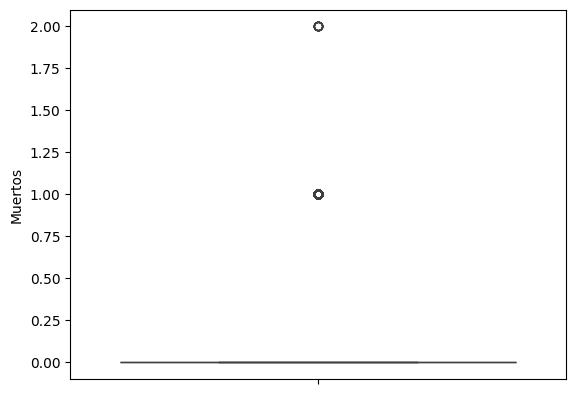

In [171]:
sns.boxplot(df['Muertos'])
plt.show()

Los digramas de cajas y el histograma muestran que los valores de 1 y 2 pueden ser posibles candidatos atipicos. En particular se estarian considerando un total de 252 observaciones (aproximadamente 1% del total). 

In [177]:
median = df['Muertos'].median()
mad = (df['Muertos'] - median).abs().median()
lower_bound = median - 3 * mad
upper_bound = median + 3 * mad

In [178]:
outlier_ind = df[(df['Muertos'] < lower_bound) | (df['Muertos'] > upper_bound)].index
len(outlier_ind)

252

Los graficos y el flitro de Hampel han marcado a las 252 observaciones en cuestión como datos atipicos. Sin embargo, por la estrucutra que presentaron los datos, faltantes es necesario revisar su los datos atipicos no estan contenidos en un clase particular.

In [179]:
df['es_outlier'] = df.index.isin(outlier_ind).astype(int)
df.groupby('Gravedad').agg(
    total=('Gravedad', 'size'),
    Casos=('es_outlier', 'sum'),
    Proporcion=('es_outlier', lambda x: round(x.mean(), 2)),
    Procentaje=('es_outlier', lambda x: round(x.mean() * 100, 3))
).reset_index()

,Gravedad,total,Casos,Proporcion,Procentaje
0,Con heridos,9901,0,0.0,0.0
1,Con muertos,252,252,1.0,100.0
2,Solo daños,15457,0,0.0,0.0


Los resultados muestran que todos los datos atípicos están concentrados en la categoría "con muertos". Esto sugiere que los valores observados en la variable Muertos probablemente reflejan la gravedad real de los accidentes en lugar de ser errores de digitación. Transformar estos datos en faltantes e imputarlos no es una estrategia adecuada, ya que podría distorsionar el análisis y subestimar la gravedad de ciertos accidentes. Por lo tanto, se ha decidido mantener intactos estos valores, preservando la integridad de los datos y asegurando que el análisis refleje fielmente la realidad de los hechos observados.

## Muertos

Procedemos de la misma manera que con la variable `Muertos`.

In [181]:
df['Heridos'].describe(percentiles=[.25, .5, .75])

count    25441.000000
mean         0.577532
std          1.020531
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         42.000000
Name: Heridos, dtype: float64

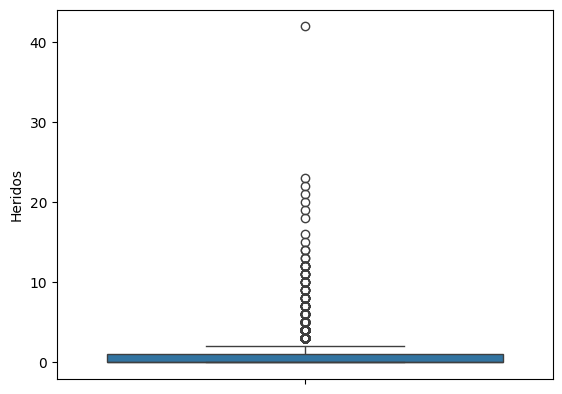

In [182]:
sns.boxplot(df['Heridos'])
plt.show()

Los graficos revelan la existencia de valores atipicos en la variable `Heridos`. Por lo cual, antes de proseguir utilizaremos el filtro de Hampel y el método de los percentiles para estudiar más a profundidad estas observaciones.

In [183]:
# Identificación de outliers usando percentiles
lower_bound = df['Heridos'].quantile(0.025)
upper_bound = df['Heridos'].quantile(0.975)
outlier_ind = df[(df['Heridos'] < lower_bound) | (df['Heridos'] > upper_bound)].index
df['Perc'] = df.index.isin(outlier_ind).astype(int)
len(outlier_ind)

303

In [185]:
# Filtro de Hampel
median = df['Heridos'].median()
mad = (df['Heridos'] - median).abs().median()
lower_bound = median - 3 * mad
upper_bound = median + 3 * mad

In [186]:
outlier_ind = df[(df['Heridos'] < lower_bound) | (df['Heridos'] > upper_bound)].index
df['Hampel'] = df.index.isin(outlier_ind).astype(int)
len(outlier_ind)

9984

In [187]:
pd.crosstab(df['Hampel'], df['Perc'])

Perc,0,1
Hampel,,
0,15626,0
1,9681,303


Tal como en la variable anterior, es necesario revisar su los datos atipicos no estan contenidos en un clase particular.

In [189]:
df.groupby('Gravedad').agg(
    total=('Gravedad', 'size'),
    Casos_Hampel=('Hampel', 'sum'),
    Casos_perc=('Perc', 'sum'),
    Procentaje_Hampel=('Hampel', lambda x: round(x.mean() * 100, 3)),
    Procentaje_perc=('Perc', lambda x: round(x.mean() * 100, 3)),
).reset_index()

,Gravedad,total,Casos_Hampel,Casos_perc,Procentaje_Hampel,Procentaje_perc
0,Con heridos,9901,9901,297,100.000,3.000
1,Con muertos,252,83,6,32.937,2.381
2,Solo daños,15457,0,0,0.000,0.000


Notamos que, tal como se reporte en la variable `Muertos`, los datos atípicos están concentrados en la categoría "con heridos". Esto sugiere que los valores observados en la variable `Heridos` probablemente reflejan la gravedad real de los accidentes en lugar de ser errores de digitación. Por lo tanto, se ha decidido mantener intactos estos valores.

# Parte 2

## Introducción

Durante esta actividad, se trabajará con la base de datos precios_2023, la cual contiene información sobre el precio del combustible en Colombia durante 2023. Esta base de datos está disponible en la página oficial del Ministerio de Minas y Energía. Los datos incluyen registros sobre el precio del combustible en diversas estaciones de servicio del país, junto con la marca, el tipo de producto, la fecha de registro, el departamento, el municipio y el precio del combustible.

In [41]:
# Cargar y limpiar los datos
df = pd.read_excel("C:/Users/jcami/Downloads/precios_2023.xlsx")
df.columns = df.columns.str.lower().str.replace(' ', '_')

El análisis de las dimensiones muestra que la base de datos está compuesta por 267,943 observaciones y siete variables:

In [42]:
# Resumen de la base de datos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267943 entries, 0 to 267942
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   bandera           267943 non-null  object
 1   nombre_comercial  267943 non-null  object
 2   producto          267943 non-null  object
 3   fecha_registro    267943 non-null  object
 4   departamento      267943 non-null  object
 5   municipio         267943 non-null  object
 6   valor_precio      267943 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 14.3+ MB
None


A continuación, se presentan las primeras 6 observaciones de la base de datos:

In [4]:
print(df.head(6))

  bandera                           nombre_comercial       producto  \
0  TERPEL        ESTACIONDESERVICIOFLUVIALBALSAJUNIN  GASOLINAMOTOR   
1  TERPEL             ESTACIONDESERVICIOBALSASANJOSE  GASOLINAMOTOR   
2  TERPEL        ESTACIONDESERVICIOFLUVIALBALSAJUNIN         DIESEL   
3  TERPEL             ESTACIONDESERVICIOBALSASANJOSE         DIESEL   
4  TERPEL  ESTACIONDESERVICIODISTRIBUIDORAELPORVENIR  GASOLINAMOTOR   
5  TERPEL  ESTACIONDESERVICIODISTRIBUIDORAELPORVENIR         DIESEL   

  fecha_registro departamento municipio  valor_precio  
0    01-Apr-2023     AMAZONAS   LETICIA         12968  
1    01-Apr-2023     AMAZONAS   LETICIA         13000  
2    01-Apr-2023     AMAZONAS   LETICIA         11800  
3    01-Apr-2023     AMAZONAS   LETICIA         11980  
4    01-Apr-2023     AMAZONAS   LETICIA         12605  
5    01-Apr-2023     AMAZONAS   LETICIA         11800  


Ahora procedemos a ajustar el tipo de datos, a cambiar a minuscula el texto, y a reducir nombres para hacerlos más manejables en analisis posteriores:

In [43]:
cols_to_lower = ["bandera", "nombre_comercial", "producto", "departamento", "municipio"]
df[cols_to_lower] = df[cols_to_lower].apply(lambda x: x.str.lower())
df['bandera'] = df['bandera'].str.replace("zapatayvelasquez", "zapata")
df[cols_to_lower] = df[cols_to_lower].astype('category')
df['fecha_registro'] = pd.to_datetime(df['fecha_registro'], format='%d-%b-%Y')

Finalmente concluimos esta primera sección, con una descripción general de la base de datos:

In [6]:
print(df.describe(include='all'))

       bandera          nombre_comercial       producto  \
count   267943                    267943         267943   
unique      23                      5910              3   
top     terpel  edsautomotrizsanjosemina  gasolinamotor   
freq     94823                       546         127338   
mean       NaN                       NaN            NaN   
min        NaN                       NaN            NaN   
25%        NaN                       NaN            NaN   
50%        NaN                       NaN            NaN   
75%        NaN                       NaN            NaN   
max        NaN                       NaN            NaN   
std        NaN                       NaN            NaN   

                       fecha_registro departamento    municipio  valor_precio  
count                          267943       267943       267943  2.679430e+05  
unique                            NaN           33          910           NaN  
top                               NaN       narino 

## Estudio de las varibales

### Bandera

La variable `Bandera` indica la marca del combustible. El análisis de esta variable iniciara construyendo una tabla de frecuencia que nos ayudara a determinar el número de observaciones en cada condición y la posible existencia de datos faltantes. 

In [6]:
bandera_freq = df['bandera'].value_counts().reset_index()
bandera_freq.columns = ['bandera', 'n']
bandera_freq['proporcion'] = bandera_freq['n'] / bandera_freq['n'].sum()
bandera_freq['porcentaje'] = bandera_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(bandera_freq)

         bandera      n  proporcion porcentaje
0         terpel  94823    0.353892     35.39%
1         primax  36112    0.134775     13.48%
2         biomax  32225    0.120268     12.03%
3         texaco  27092    0.101111     10.11%
4       petromil  17249    0.064376      6.44%
5   coomulpinort   8918    0.033283      3.33%
6    ayatawacoop   8057    0.030070      3.01%
7          zeuss   7488    0.027946      2.79%
8      petrobras   4871    0.018179      1.82%
9    discowacoop   3895    0.014537      1.45%
10          ecos   3613    0.013484      1.35%
11          esso   3502    0.013070      1.31%
12     petrdecol   3495    0.013044      1.30%
13    petrodecol   3337    0.012454      1.25%
14          puma   3059    0.011417      1.14%
15        discom   2917    0.010887      1.09%
16        octano   2221    0.008289      0.83%
17       plusmas   1806    0.006740      0.67%
18           pyb   1684    0.006285      0.63%
19          brio    719    0.002683      0.27%
20        zap

Ahora examinamos el número de datos faltantes:

In [126]:
print(df['bandera'].isna().sum())

0


Debido a que la tabla de frencuencia muestra que no hay datos faltantes en esta variable, se culmina el estudio inicial de la variable `Bandera` visualizando el número de  observaciones por bandera en un diagrama de barras.

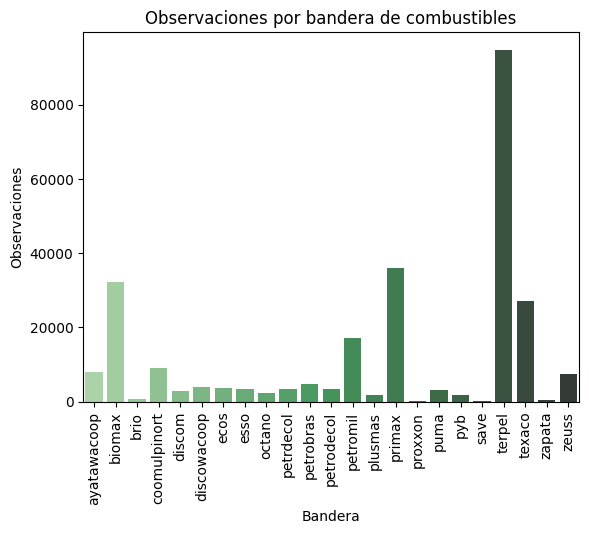

In [132]:
sns.barplot(x='bandera', y='n', hue='bandera', data=bandera_freq, palette='Greens_d', dodge=False)
plt.title("Observaciones por bandera de combustibles")
plt.xlabel("Bandera")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.show()

### Producto

La variable `Producto` indica el tipo de combustible. Tal como en la variable anterior, se construira una tabla de frecuencia para determinar el número de observaciones en cada condición y la posible existencia de datos faltantes. 

In [130]:
producto_freq = df['producto'].value_counts().reset_index()
producto_freq.columns = ['producto', 'n']
producto_freq['proporcion'] = producto_freq['n'] / producto_freq['n'].sum()
producto_freq['porcentaje'] = producto_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(producto_freq)

        producto       n  proporcion porcentaje
0  gasolinamotor  127338    0.475243     47.52%
1         diesel  108205    0.403836     40.38%
2          extra   32400    0.120921     12.09%


Ahora examinamos el número de datos faltantes:

In [ ]:
print(df['producto'].isna().sum())

Debido a que la tabla de frencuencia muestra que no hay datos faltantes en esta variable, se culmina el estudio inicial de la variable `Producto` visualizando el número de observaciones por bandera en un diagrama de barras.

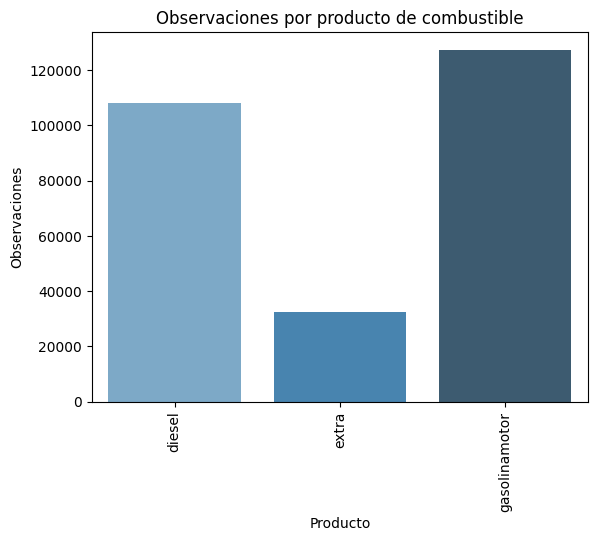

In [139]:
sns.barplot(x='producto', y='n', hue='producto', data=producto_freq, palette='Blues_d', dodge=False)
plt.title("Observaciones por producto de combustible")
plt.xlabel("Producto")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.show()

### Fecha de registro

Tal como su nombre de indica, la varibale `fecha_registro` ofrece información sobre la fecha en donde se recolecto la información. Debido a la naturaleza de esta varibale no es recomendable darle el mismo tratamiento aplicado en las secciones anteriores.En este caso, comenzaremos verificando el número de datos faltantes.

In [140]:
print(df['fecha_registro'].isna().sum())

0


Dado que no se han encontrado datos faltantes, se procedera visualizar el número de observaciones a lo largo del tiempo:

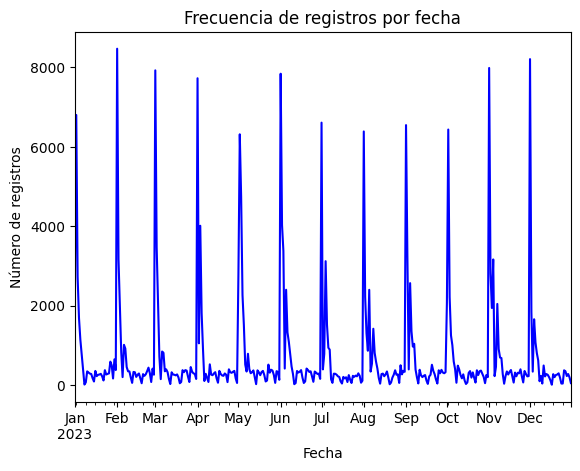

In [141]:
df['fecha_registro'].value_counts().sort_index().plot(kind='line', color='blue')
plt.title("Frecuencia de registros por fecha")
plt.xlabel("Fecha")
plt.ylabel("Número de registros")
plt.show()

De manera similar, podemos extraer los meses de la variable `fecha_registro` y estudiar el número de observaciones en cada uno de ellos. Esto se muestra acontinuación:

In [142]:
df['mes'] = df['fecha_registro'].dt.month_name()
mes_freq = df['mes'].value_counts().reset_index()
mes_freq.columns = ['mes', 'n']
mes_freq['proporcion'] = mes_freq['n'] / mes_freq['n'].sum()
mes_freq['porcentaje'] = mes_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(mes_freq)

          mes      n  proporcion porcentaje
0        June  26887    0.100346     10.03%
1    November  25872    0.096558      9.66%
2         May  25590    0.095505      9.55%
3     January  22369    0.083484      8.35%
4    February  22206    0.082876      8.29%
5       March  22125    0.082574      8.26%
6      August  21959    0.081954      8.20%
7   September  21927    0.081835      8.18%
8       April  21635    0.080745      8.07%
9     October  19487    0.072728      7.27%
10   December  19433    0.072527      7.25%
11       July  18453    0.068869      6.89%


Con estos datos podemos generar un diagrama de barras con el fin de visualizar el número de observaciones en cada uno de los meses:

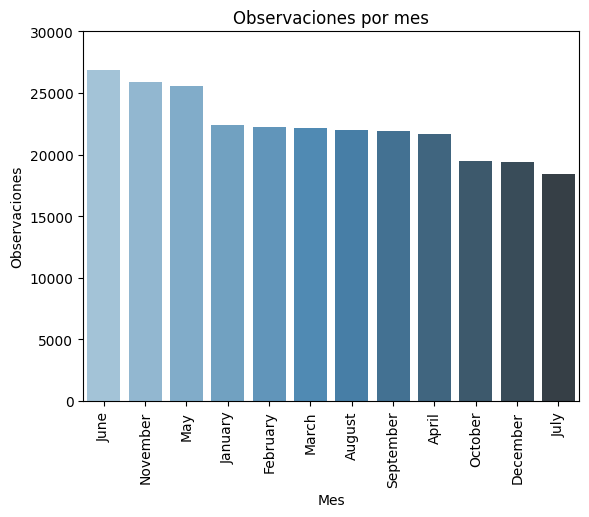

In [144]:
sns.barplot(x='mes', y='n',hue = 'mes',data=mes_freq, palette='Blues_d')
plt.title("Observaciones por mes")
plt.xlabel("Mes")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.ylim(0, 30000)
plt.show()


### Municipio y Departamento

Las variables `departamento` y `municipio` contienen información sobre el lugar donde se registro la información. Debido a que estas variables son categoricas primer se examinaran sus tablas de frecuencia y se revisar la posibles presencias de datos faltantes.

In [146]:
departamento_freq = df['departamento'].value_counts().reset_index()
departamento_freq.columns = ['departamento', 'n']
departamento_freq['proporcion'] = departamento_freq['n'] / departamento_freq['n'].sum()
departamento_freq['porcentaje'] = departamento_freq['proporcion'].apply(lambda x: f"{x:.2%}")

print(departamento_freq)

          departamento      n  proporcion porcentaje
0         cundinamarca  32662    0.121899     12.19%
1               narino  31054    0.115898     11.59%
2            antioquia  25009    0.093337      9.33%
3   norte de santander  21752    0.081181      8.12%
4      valle del cauca  18754    0.069992      7.00%
5                cesar  15703    0.058606      5.86%
6           la guajira  13636    0.050891      5.09%
7            santander  10247    0.038243      3.82%
8            atlantico   8595    0.032078      3.21%
9               tolima   8014    0.029909      2.99%
10              boyaca   7769    0.028995      2.90%
11             cordoba   7440    0.027767      2.78%
12             bolivar   7027    0.026226      2.62%
13            putumayo   6610    0.024669      2.47%
14               huila   6355    0.023718      2.37%
15                meta   6250    0.023326      2.33%
16               cauca   5617    0.020963      2.10%
17           risaralda   5435    0.020284     

En el caso particular del `municipio`, la inspección de la tabla de frecuencia no es recomendable bebido a la gran número de categorias. Por lo cual, se solo nos hemos limitado a mostrar los 10 primeros municipios:

In [164]:
municipio_freq = df['municipio'].value_counts().reset_index()
municipio_freq.columns = ['municipio', 'n']
municipio_freq = municipio_freq.head(5)  # Seleccionar solo los 10 municipios más frecuentes
municipio_freq['proporcion'] = municipio_freq['n'] / municipio_freq['n'].sum()
municipio_freq['porcentaje'] = municipio_freq['proporcion'].apply(lambda x: f"{x:.2%}")

print(municipio_freq)

           municipio      n  proporcion porcentaje
0        bogota,d.c.  16031    0.385629     38.56%
1               cali   7388    0.177720     17.77%
2  sanandresdetumaco   6540    0.157321     15.73%
3    sanjosedecucuta   6183    0.148733     14.87%
4           medellin   5429    0.130596     13.06%


Ahora procedemos a revisar el número de datos faltantes:

In [148]:
print(df['departamento'].isna().sum()) # Faltantes en departamento

0


In [149]:
print(df['municipio'].isna().sum()) # Faltantes en municipio

0


Ahora se procede a generar dos diagramas de barras para visualizar el número de observaciones en cada una de la categorias:

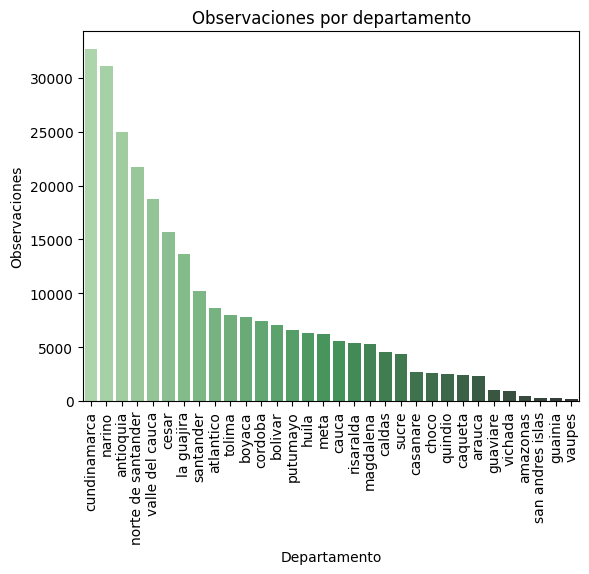

In [150]:
sns.barplot(x='departamento', y='n', hue = 'departamento', data=departamento_freq, palette='Greens_d')
plt.title("Observaciones por departamento")
plt.xlabel("Departamento")
plt.ylabel("Observaciones")
plt.xticks(rotation=90)
plt.show()

## Comercio

La variable `nombre_comercial` contiene información sobre las estaciones de servicios en donde se recolecto la información del valor de la gasolina. Esta varibale contiene un gran cantidad de niveles que no permiten un análisis directo de cada una de las categorias. Por lo cual, comenzaremos transformando la variable a factor y examinando si contiene datos faltantes:

In [173]:
df['nombre_comercial'] = df['nombre_comercial'].astype('category')
print(df['nombre_comercial'].isna().sum())

0


Debido a que no se encontraron datos faltantes, se procedera a constrir una tabla de frecuencia con datos descriptivos:

In [14]:
nombre_comercial_freq = df['nombre_comercial'].value_counts().reset_index()
nombre_comercial_freq.columns = ['nombre_comercial', 'n']
nombre_comercial_freq['proporcion'] = nombre_comercial_freq['n'] / nombre_comercial_freq['n'].sum()
nombre_comercial_freq['porcentaje'] = nombre_comercial_freq['proporcion'].apply(lambda x: f"{x:.2%}")
print(nombre_comercial_freq)

                         nombre_comercial    n  proporcion porcentaje
0                edsautomotrizsanjosemina  546    0.002038      0.20%
1         estaciondeserviciojltsanalberto  459    0.001713      0.17%
2          estaciondeserviciosanfrancisco  441    0.001646      0.16%
3     estaciondeservicioautomotrizfullleo  361    0.001347      0.13%
4                  estaciondeserviciootun  353    0.001317      0.13%
...                                   ...  ...         ...        ...
5905   estaciondeservicioyboteelhorizonte    2    0.000007      0.00%
5906        estaciondeserviciolavegasupia    2    0.000007      0.00%
5907              estaciondeserviciomario    2    0.000007      0.00%
5908              ancombustiblespacificrs    2    0.000007      0.00%
5909           e.d.scombustibleslaperlita    1    0.000004      0.00%

[5910 rows x 4 columns]


### Precio del combustible

Finalmente, se examinara la variable `valor_precio` la cual contiene el valor de la gasolina en cada una de las estaciones del país. Primeramente comenzaremos graficando un histograma y un diagramas de caja que nos ayudara estudiar la distribución de la variable y posible datos atipicos:

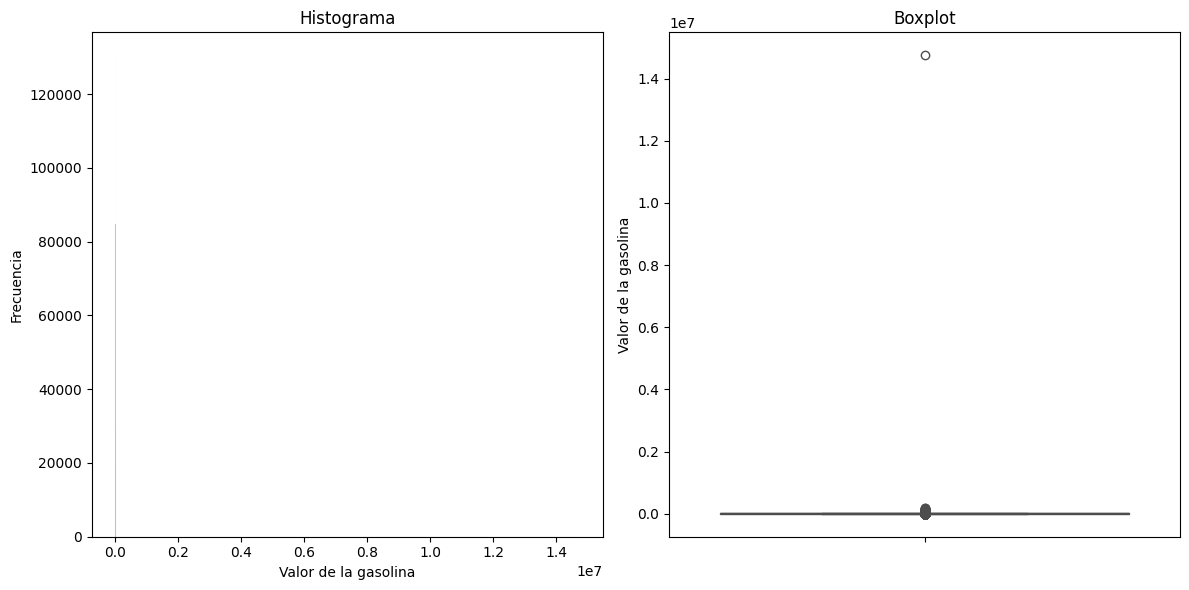

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['valor_precio'], binwidth=3600, color='cyan', edgecolor='black')
plt.title('Histograma')
plt.xlabel('Valor de la gasolina')
plt.ylabel('Frecuencia')

# Diagrama de caja
plt.subplot(1, 2, 2)
sns.boxplot(y=df['valor_precio'], color='cyan')
plt.title('Boxplot')
plt.xlabel('')
plt.ylabel('Valor de la gasolina')

plt.tight_layout()
plt.show()

Los graficos revelan la existencia de valores atipicos en la variable `valor_precio` . Asi mismo, se encuentran valores no aceptables en la varibale (p.e valor de gasolina 0). Por lo cual, antes de proseguir utilizaremos el filtro de Hampel y el método de los percentiles para estudiar más a profundidad estas observaciones.

In [45]:
def hampel_filter(values, window_size=7, n_sigmas=3):
    """Aplicar el filtro de Hampel para detectar outliers."""
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    lower_bound = median - n_sigmas * mad
    upper_bound = median + n_sigmas * mad
    return lower_bound, upper_bound

# Aplicar el filtro de Hampel
lower_bound, upper_bound = hampel_filter(df['valor_precio'].dropna())
df['Hampel'] = df['valor_precio'].apply(lambda x: 1 if x < lower_bound or x > upper_bound else 0)

# Usar percentiles
lower_bound_perc = df['valor_precio'].quantile(0.025)
upper_bound_perc = df['valor_precio'].quantile(0.975)
df['Perc'] = df['valor_precio'].apply(lambda x: 1 if x < lower_bound_perc or x > upper_bound_perc else 0)

# Número de outliers
print("Número de outliers Hampel:", df['Hampel'].sum())
print("Número de outliers Percentiles:", df['Perc'].sum())

Número de outliers Hampel: 30771
Número de outliers Percentiles: 13386


Ahora se examinaran el número de datos atipicos en función a la diferentes categorias presentes en la base de datos:

In [46]:
grouped_by_bandera = df.groupby('bandera').agg(
    Casos_Hampel=('Hampel', 'sum'),
    Casos_perc=('Perc', 'sum'),
    Porcentaje_Hampel=('Hampel', lambda x: round((x.sum() / 30771) * 100, 3)),
    Porcentaje_perc=('Perc', lambda x: round((x.sum() / 13386) * 100, 3))
)
print(grouped_by_bandera)

              Casos_Hampel  Casos_perc  Porcentaje_Hampel  Porcentaje_perc
bandera                                                                   
ayatawacoop             44         524              0.143            3.915
biomax                2052         809              6.669            6.044
brio                    83          34              0.270            0.254
coomulpinort           120        1958              0.390           14.627
discom                 106           8              0.344            0.060
discowacoop              0        1724              0.000           12.879
ecos                   283           4              0.920            0.030
esso                   622         294              2.021            2.196
octano                 251           0              0.816            0.000
petrdecol                2          13              0.006            0.097
petrobras              750         178              2.437            1.330
petrodecol               

In [47]:
grouped_by_producto = df.groupby('producto').agg(
    Casos_Hampel=('Hampel', 'sum'),
    Casos_perc=('Perc', 'sum'),
    Porcentaje_Hampel=('Hampel', lambda x: round((x.sum() / 30771) * 100, 3)),
    Porcentaje_perc=('Perc', lambda x: round((x.sum() / 13386) * 100, 3))
)
print(grouped_by_producto)

               Casos_Hampel  Casos_perc  Porcentaje_Hampel  Porcentaje_perc
producto                                                                   
diesel                  154        6519              0.500            48.70
extra                 29714        6618             96.565            49.44
gasolinamotor           903         249              2.935             1.86


Notamos que el procentaje de datos atipicos depende del tipo de producto, espacialmente al utlizar el filtro de Hampel. Debido a esto procederemos a construir un diagrama de cajas por grupos del valor de la gasolina:

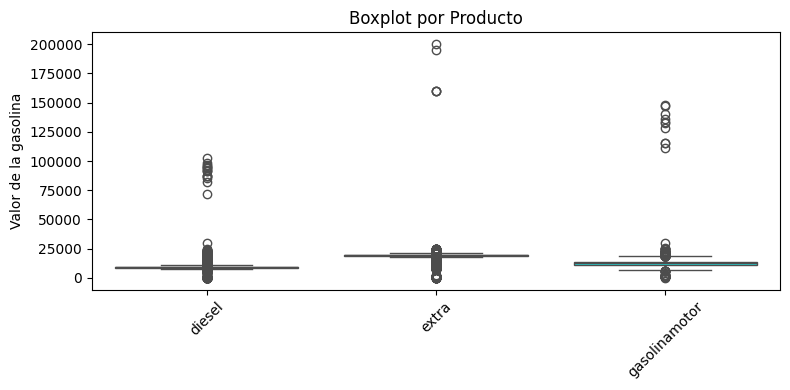

In [48]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='producto', y='valor_precio', data=df[df['valor_precio'] < 300000], color='cyan')
plt.title('Boxplot por Producto')
plt.xlabel('')
plt.ylabel('Valor de la gasolina')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Los datos muestran que aun cuando se considera el tipo de producto, los valores mayores a 50.000 se desvian considerablemente de las distribuciones. Para confirmar estas observaciones se realizo la prueba de Rosner de `R`, la cual concluyo que que los valores mayores a 30.000 como datos atipicos, pero no se marcaron los valores en cero. En vista de esto, se procedera a reemplazar los valores atipicos y aquellos los menores a 1000 como faltantes.

In [49]:
df['valor_precio'] = df['valor_precio'].apply(lambda x: np.nan if x < 1000 or x > 30000 else x)

Ahora volveremos a graficar el valor del combustible:

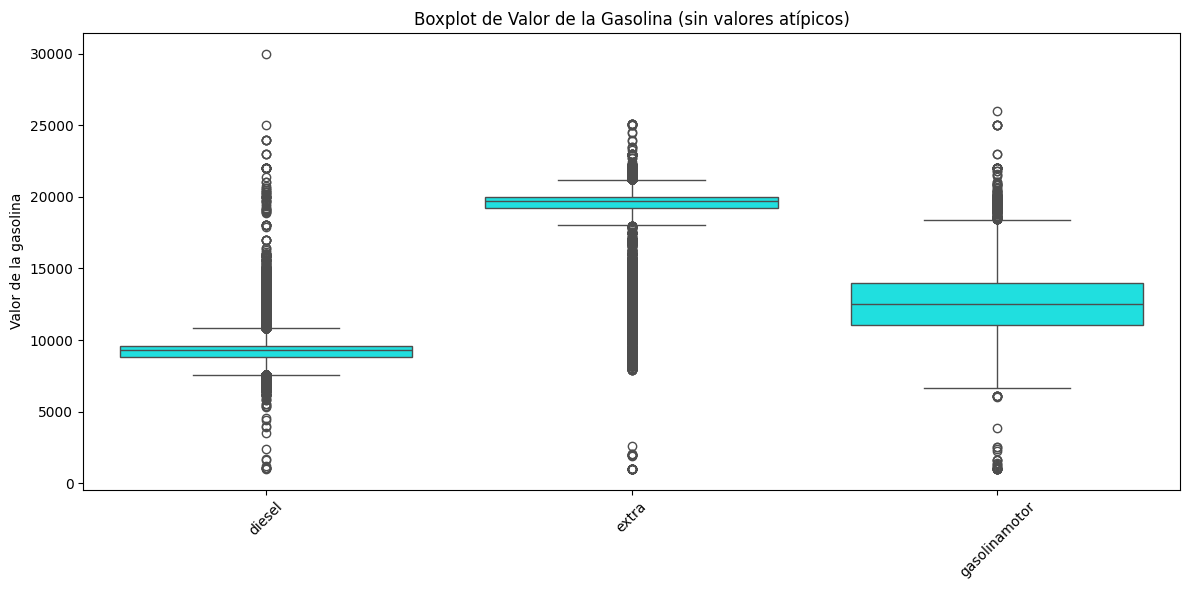

In [50]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='producto', y='valor_precio', data=df, color='cyan')
plt.title('Boxplot de Valor de la Gasolina (sin valores atípicos)')
plt.xlabel('')
plt.ylabel('Valor de la gasolina')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finalmente, calcularemos estadisticas descriptivas de la varibale `valor_precio`:

In [36]:
summary_stats = df['valor_precio'].describe(percentiles=[.025, .975])
print(summary_stats)

count    267843.000000
mean      11958.866291
std        3484.321741
min        1000.000000
2.5%       7550.000000
50%       10880.000000
97.5%     20120.000000
max       30000.000000
Name: valor_precio, dtype: float64


### Imputación

Ahora procederemos a tratar con los datos faltantes. Primero calcularemos el procentaje de datos faltantes en la base de datos.

In [51]:
missing_data = df.isnull().mean() * 100
print(missing_data)

bandera             0.000000
nombre_comercial    0.000000
producto            0.000000
fecha_registro      0.000000
departamento        0.000000
municipio           0.000000
valor_precio        0.037321
Hampel              0.000000
Perc                0.000000
dtype: float64


El analisis muestra que la unica varibale que contiene datos faltantes es el valor del combustible, siendo aproximadamente un 0.04% del total de observaciones. En vista de esto, utilizaremos la mediana para imputar los datos de la variable. Este método se seleccionó por dos razones: 1) la inspección de los datos indica que no siguen una distribución normal, y 2) la baja proporción de datos faltantes sugiere que la pérdida de varianza asociada con la imputación simple puede ser aceptable. Sin embargo, se reconocen las ventajas de la imputación múltiple, y se sugiere realizar este ejercicio cuando se disponga de mayores recursos computacionales.

In [52]:
# Guardar los datos originales antes de la imputación
df_antes_imput = df['valor_precio'].copy()

# Imputar los valores faltantes con la mediana
median_value = df['valor_precio'].dropna().median()
df['valor_precio'].fillna(median_value, inplace=True)

In [53]:
df_A = pd.DataFrame({
    'valor': df_antes_imput,
    'imput': 'antes'
})

df_B = pd.DataFrame({
    'valor': df['valor_precio'],
    'imput': 'despues'
})

print(df_A['valor'].isna().sum())
print(df_B['valor'].isna().sum())

100
0


In [55]:
df_A_clean = df_A.dropna(subset=['valor'])
df_B_clean = df_B.dropna(subset=['valor'])

# Verificar la longitud de las muestras después de limpiar
print(f"Longitud de df_A_clean: {len(df_A_clean)}")
print(f"Longitud de df_B_clean: {len(df_B_clean)}")

# Asegurarse de que ambas muestras tengan la misma longitud
min_len = min(len(df_A_clean), len(df_B_clean))
df_A_clean = df_A_clean.iloc[:min_len]
df_B_clean = df_B_clean.iloc[:min_len]

stat, p_value = wilcoxon(df_A_clean['valor'], df_B_clean['valor'])
print(f"Estadístico de Wilcoxon: {stat}, p-valor: {p_value}")

Longitud de df_A_clean: 267843
Longitud de df_B_clean: 267943
Estadístico de Wilcoxon: 15590517993.0, p-valor: 0.5183060292832984


Los prueba de wilcoxon revela que la distribución de la variable no cambio despues de la imputación. Por lo cual se concluye que el proceso se llevo a cabo adecuadamente. Concluiremos esta sección graficando la variable `valor_precio` una ultima vez:

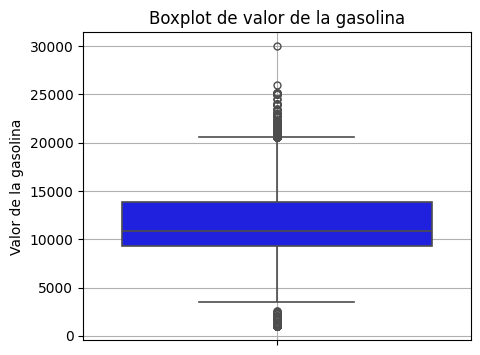

In [58]:
plt.figure(figsize=(5, 4))
sns.boxplot(y=df['valor_precio'], color='blue', fliersize=5, linewidth=1.2)
plt.title("Boxplot de valor de la gasolina")
plt.xlabel("")
plt.ylabel("Valor de la gasolina")
plt.grid(True)
plt.show()

### Análisis Adicional

Antes de proceder a visualizar los precios de la gasolina en el mapa de Colombia, realizaremos algunos análisis y visualizaciones adicionales para obtener una comprensión más profunda de los datos. Primero, examinaremos la distribución de los precios del combustible por tipo utilizando un diagrama de caja.

#### Distribución de Precios por Tipo de Combustible

El diagrama de caja muestra la distribución de precios para diferentes tipos de combustibles. Este gráfico es útil para identificar la variabilidad y los valores atípicos en los precios de cada tipo de combustible.

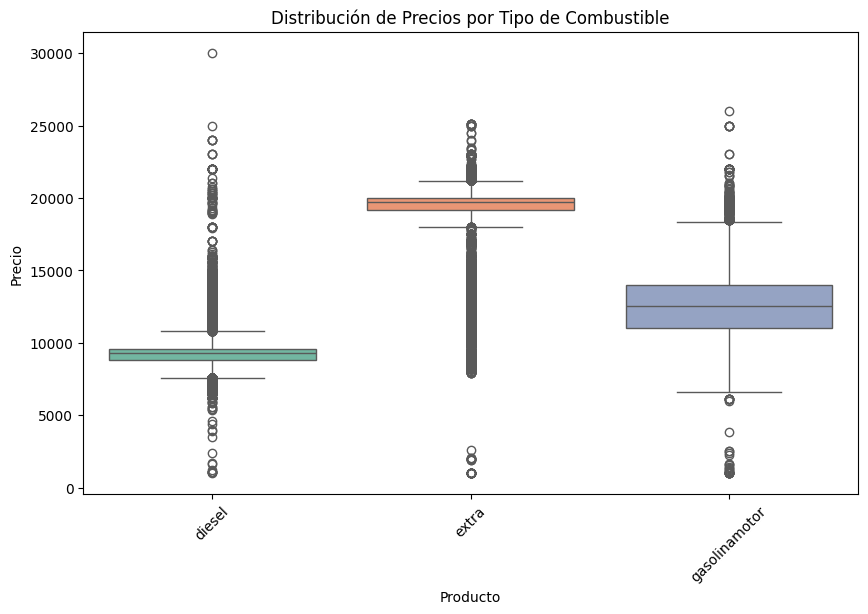

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='producto', y='valor_precio', data=df, palette="Set2")
plt.title("Distribución de Precios por Tipo de Combustible")
plt.xlabel("Producto")
plt.ylabel("Precio")
plt.xticks(rotation=45)
plt.show()

Este gráfico sugiere que la gasolina extra tiende a tener un valor promedio más alto en comparación con la gasolina motor y el diésel. Esto se alinea con las tendencias generales del mercado de los últimos años.

#### Precio Promedio del Diésel por Departamento

A continuación, visualizaremos el precio promedio del diésel en cada departamento del país. Esta visualización permitirá identificar las regiones donde el precio del diésel es más alto.

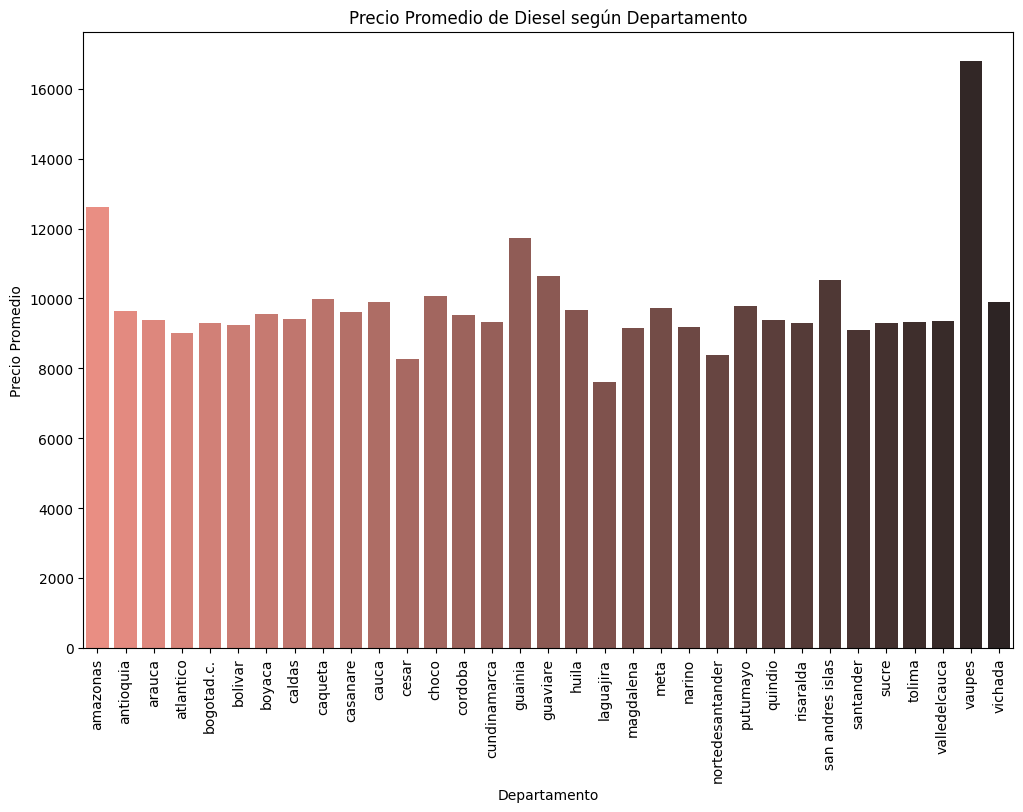

In [62]:
df_diesel = df[df['producto'] == 'diesel']
df_diesel_resum = df_diesel.groupby('departamento')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='departamento', y='valor_precio', data=df_diesel_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Diesel según Departamento")
plt.xlabel("Departamento")
plt.ylabel("Precio Promedio")
plt.xticks(rotation=90)
plt.show()

Se observa que los departamentos de Vaupés, Amazonas y Guainía presentan los precios más altos para el diésel.

#### Precio Promedio de la Gasolina Extra por Departamento

Ahora procederemos a visualizar el precio promedio de la gasolina extra en los diferentes departamentos del país.

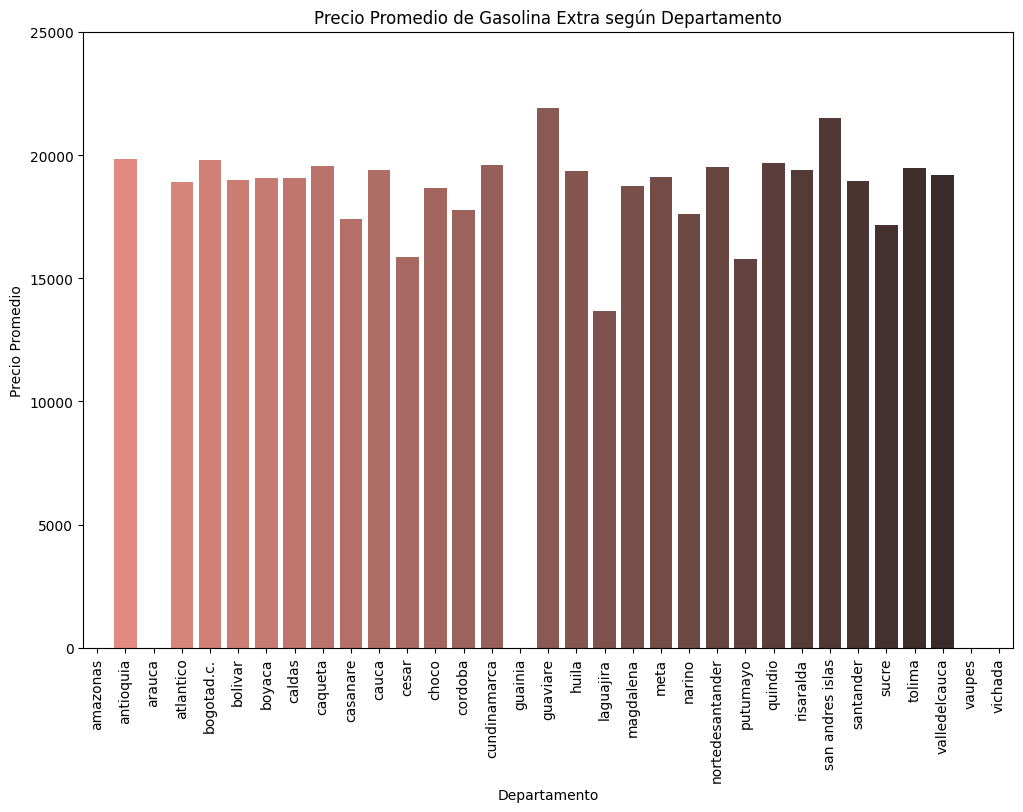

In [69]:
df_extra = df[df['producto'] == 'extra']
df_extra_resum = df_extra.groupby('departamento')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='departamento', y='valor_precio', data=df_extra_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Gasolina Extra según Departamento")
plt.xlabel("Departamento")
plt.ylabel("Precio Promedio")
plt.ylim(0, 25000)
plt.xticks(rotation=90)
plt.show()

#### Precio Promedio de Gasolina Motor por Departamento

Ahora el precio de la gasolina motor por departamento:

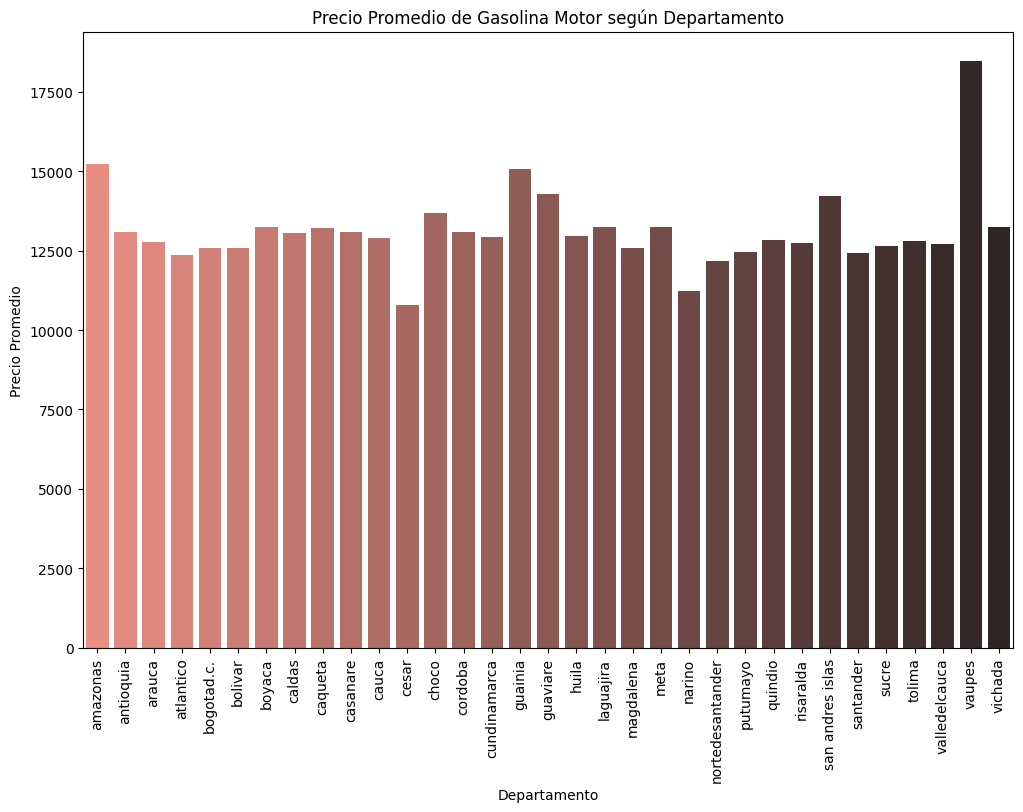

In [70]:
df_motor = df[df['producto'] == 'gasolinamotor']
df_motor_resum = df_motor.groupby('departamento')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='departamento', y='valor_precio', data=df_motor_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Gasolina Motor según Departamento")
plt.xlabel("Departamento")
plt.ylabel("Precio Promedio")
plt.xticks(rotation=90)
plt.show()

####  Precio Promedio de la Gasolina por Marca (o Bandera)

Por último, examinaremos el precio promedio de cada tipo de gasolina según la marca o bandera. Esto nos permitirá comparar cómo varían los precios entre diferentes marcas.

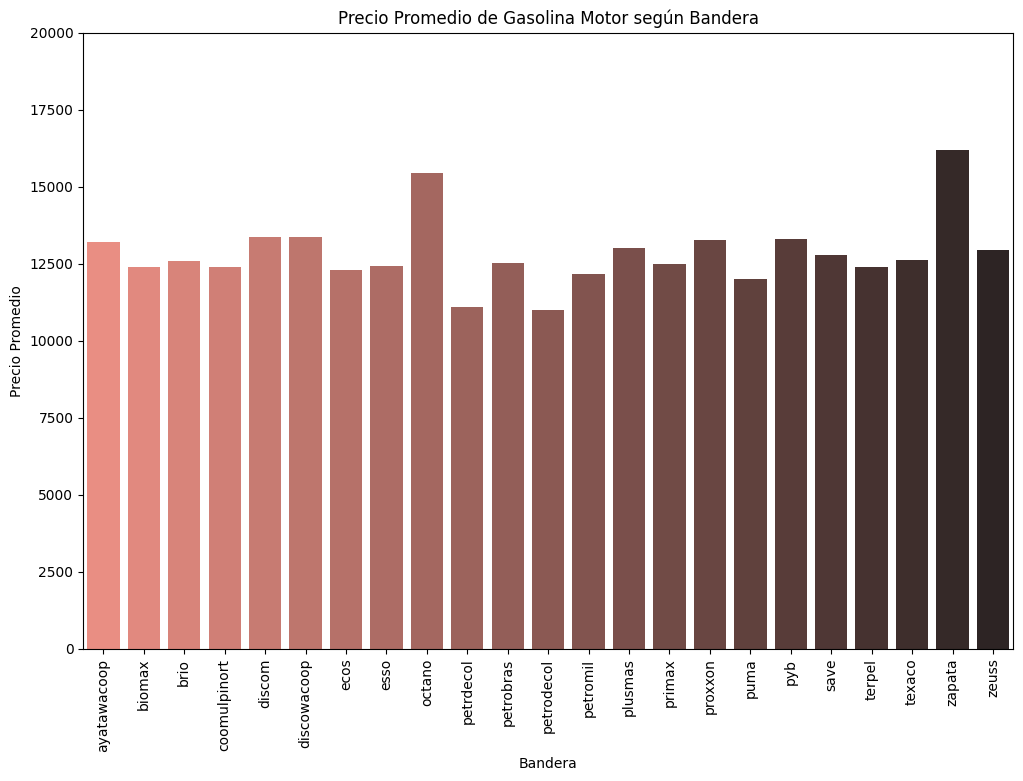

In [75]:
# Para gasolina motor
df_motor_brand = df[df['producto'] == 'gasolinamotor']
df_motor_brand_resum = df_motor_brand.groupby('bandera')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='bandera', y='valor_precio', data=df_motor_brand_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Gasolina Motor según Bandera")
plt.xlabel("Bandera")
plt.ylabel("Precio Promedio")
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.show()


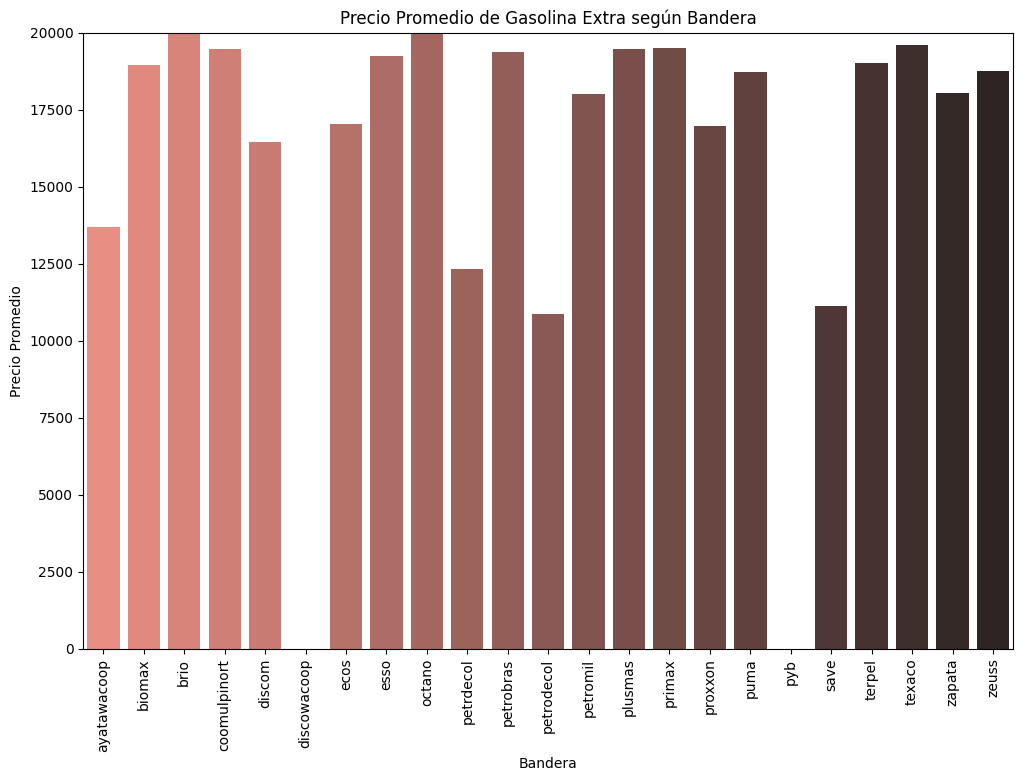

In [76]:
df_extra_brand = df[df['producto'] == 'extra']
df_extra_brand_resum = df_extra_brand.groupby('bandera')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='bandera', y='valor_precio', data=df_extra_brand_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Gasolina Extra según Bandera")
plt.xlabel("Bandera")
plt.ylabel("Precio Promedio")
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.show()

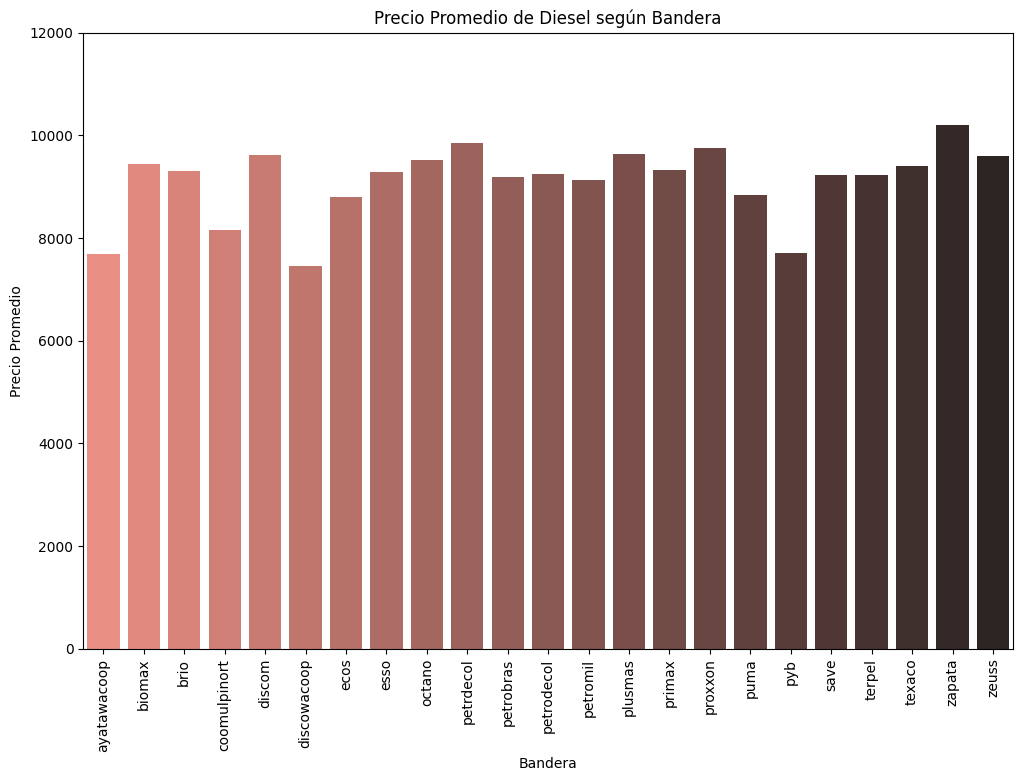

In [78]:
df_diesel_brand = df[df['producto'] == 'diesel']
df_diesel_brand_resum = df_diesel_brand.groupby('bandera')['valor_precio'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='bandera', y='valor_precio', data=df_diesel_brand_resum, palette="dark:salmon_r")
plt.title("Precio Promedio de Diesel según Bandera")
plt.xlabel("Bandera")
plt.ylabel("Precio Promedio")
plt.ylim(0, 12000)
plt.xticks(rotation=90)
plt.show()

## Mapa

En la ultima sección de este ejercicio se graficara el precio de la gasolina motor en cada departamente de colombia utilizando un mapa de Colombia.

In [79]:
mapa_ant = gpd.read_file("C:/Users/jcami/OneDrive/Escritorio/DATAVIZ/Departamentos_Junio_2024_shp/Departamentos_Junio_2024_shp/Departamento.shp")
mapa_ant['geometry'] = mapa_ant['geometry'].apply(lambda geom: make_valid(geom))

Ahora se extraen los nombres de los departamentos desde la base de datos y el archivo shapefile. Los nombres se convierten a minúsculas y se eliminan caracteres especiales para facilitar la comparación. Esto asegura que los nombres de los departamentos en ambas fuentes sean comparables.

In [10]:
df['departamento'] = df['departamento'].str.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ñ', 'n').replace('ü', 'u').str.lower()
mapa_ant['DeNombre'] = mapa_ant['DeNombre'].str.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ñ', 'n').replace('ü', 'u').str.lower()

Se verifica qué nombres de la base de datos no están presentes en el shapefile. Se identifican los nombres de los departamentos que no coinciden y se corrigen manualmente para que coincidan con los del shapefile.

In [11]:
def match(a, b):
    set_b = set(b)
    return [i for i in range(len(a)) if a[i] not in set_b]

In [12]:
a2 = match(df['departamento'], mapa_ant['DeNombre'])
print(df['departamento'].iloc[a2])

952       san andres islas
953       san andres islas
954       san andres islas
955       san andres islas
956       san andres islas
                ...       
267934    nortedesantander
267935    nortedesantander
267936    nortedesantander
267937    nortedesantander
267938    nortedesantander
Name: departamento, Length: 121570, dtype: object


In [13]:
a2 = match(mapa_ant['DeNombre'], df['departamento'])
print(mapa_ant['DeNombre'].iloc[a2])

0               area en litigio cauca - huila
6                                     quindío
11    san andrés providencia y santa catalina
15                                    bolívar
19                                    córdoba
20                                      chocó
21                                 la guajira
23                         norte de santander
25                            valle del cauca
29                                    guainía
30                                     vaupés
32                                     nariño
Name: DeNombre, dtype: object


In [14]:
df['departamento'].replace({
    'bogotad.c.': 'cundinamarca',
    'nortedesantander': 'norte de santander',
    'valledelcauca': 'valle del cauca',
    'laguajira': 'la guajira'
}, inplace=True)

mapa_ant['DeNombre'].replace({
    'san andres providencia y santa catalina': 'san andres islas',
    'area en litigio cauca - huila': 'huila'
}, inplace=True)

In [15]:
df["codigo"] = df['departamento']
mapa_ant["codigo"] = mapa_ant['DeNombre']

In [16]:
Datos_tot = pd.merge(mapa_ant, df, on='codigo', how='outer')

In [17]:
Datos_tot['codigo'].replace({
    'chocó': 'choco',
    'bolívar': 'bolivar',
    'córdoba': 'cordoba',
    'san andrés providencia y santa catalina': 'san andres islas',
    'guainía': 'guainia',
    'quindío': 'quindio',
    'vaupés': 'vaupes',
    'nariño': 'narino'
}, inplace=True)

Ahora se filtran los datos para obtener solo la información relevante sobre el producto "gasolinamotor". Los datos se agrupan por departamento y se calcula el precio promedio de la gasolina motor en cada uno.

In [19]:
datos_filtrados = Datos_tot.query("producto == 'gasolinamotor'")

In [20]:
datos_agregados = (datos_filtrados
                   .groupby(['codigo'])
                   .agg(precio_prom_dpto=('valor_precio', 'mean'))
                   .reset_index())

In [53]:
geometria_dptos = mapa_ant[['codigo', 'geometry']]

In [59]:
geometria_dptos['codigo'].replace({
    'bolívar': 'bolivar',
    'san andrés providencia y santa catalina': 'san andres islas'
}, inplace=True)

Debido a que se encuentran geometrias no válidas se procede a corregirlas manualmente:

In [79]:
datos_finales = pd.merge(datos_agregados, geometria_dptos, on='codigo', how='left')
gdf = gpd.GeoDataFrame(datos_finales, geometry='geometry')

In [84]:
def combine_geometries(geometries):
    return geometries.unary_union

gdf_consolidado = gdf.groupby('codigo').apply(lambda x: combine_geometries(x.geometry)).reset_index()
gdf_consolidado.columns = ['codigo', 'geometry']

gdf_precio = gdf.groupby('codigo')['precio_prom_dpto'].mean().reset_index()
gdf_consolidado = gdf_consolidado.merge(gdf_precio, on='codigo')
gdf_consolidado = gpd.GeoDataFrame(gdf_consolidado, geometry='geometry')

In [72]:
manual_polygons = pd.DataFrame({
    'codigo': ["bolivar", "choco","cordoba","guainia","narino","san andres islas", "vaupes"],
    'geometry': [geometria_dptos.loc[15, 'geometry'], geometria_dptos.loc[20, 'geometry'],geometria_dptos.loc[19, 'geometry'],
                geometria_dptos.loc[29, 'geometry'],geometria_dptos.loc[32, 'geometry'],geometria_dptos.loc[11, 'geometry'],
                geometria_dptos.loc[30, 'geometry']]  # Reemplaza 'polygon1', 'polygon2' con las geometrías correctas
})

In [86]:
gdf_consolidado.loc[4, 'geometry'] = geometria_dptos.loc[15, 'geometry']
gdf_consolidado.loc[11, 'geometry'] = geometria_dptos.loc[20, 'geometry']
gdf_consolidado.loc[12, 'geometry'] = geometria_dptos.loc[19, 'geometry']
gdf_consolidado.loc[14, 'geometry'] = geometria_dptos.loc[29, 'geometry']
gdf_consolidado.loc[20, 'geometry'] = geometria_dptos.loc[32, 'geometry']
gdf_consolidado.loc[23, 'geometry'] = geometria_dptos.loc[6, 'geometry']
gdf_consolidado.loc[25, 'geometry'] = geometria_dptos.loc[11, 'geometry']
gdf_consolidado.loc[30, 'geometry'] =  geometria_dptos.loc[30, 'geometry']

Se genera un resumen estadístico y se visualiza la distribución de los precios utilizando gráficos de caja y histogramas:

In [123]:
print(gdf_consolidado[['codigo', 'precio_prom_dpto']])

                codigo  precio_prom_dpto
0             amazonas      15236.346154
1            antioquia      13093.399409
2               arauca      12779.423077
3            atlantico      12350.908540
4              bolivar      17090.169314
5               boyaca      13239.346864
6               caldas      13045.504036
7              caqueta      13208.076658
8             casanare      13099.819985
9                cauca      12884.249272
10               cesar      10787.837878
11               choco      13692.445074
12             cordoba      13110.482459
13        cundinamarca      12764.095715
14             guainia      15053.919118
15            guaviare      14286.956747
16               huila      13007.300857
17          la guajira      13240.057188
18           magdalena      12639.437850
19                meta      13230.244919
20              narino      11240.606136
21  norte de santander      12191.534647
22            putumayo      12457.861062
23             q

Finalmente, se utiliza el método `plot()` para crear un mapa que muestra los departamentos con un color que representa el rango de precios de gasolina promedio. Se añade una leyenda al mapa para identificar las categorías de precios.

In [82]:
gdf_consolidado.plot(column="precio_prom_dpto",figsize=(14,7), legend=True, edgecolor="black",cmap='coolwarm')
plt.xticks([])
plt.yticks([])

NameError: name 'gdf_consolidado' is not defined